<a href="https://colab.research.google.com/github/sasso-effe/spotify-hit-predictor/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Bayesian Network to predict if a song of Spotify will be an hit or not

## Data and preprocessing
The dataset is taken from [Kaggle - Hit song science - 34740 songs (+spotify features)](https://www.kaggle.com/multispiros/34740-hit-and-nonhit-songs-spotify-features).

This dataset contains 34740 entries represented songs. Each entry has the following fields:
 - **artist_name**: the name of the artist;
 - **danceability**: how suitable the track is for dancing based on a combination of musical elements. 0.0 is least danceable, while 1.0 is most danceable;
 - **energy**: a perceptual measurity of intensity and activity based on dynamic range, perceived loudness, timbre, onset rate and general entropy. 0.0 is least energic, while 1.0 is most energic;
 - **key**: the estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.
 - **loudness**: the overall loudness of the track in decibels;
 - **mode**: indicate if the track is in minor (0) or major (1) modality;
 - **speechiness**: the presence of spoken words in a track. 1.0 is a track made entirely of spoken words, while 0.0 is a track without spoken words;
 - **acousticness**: a confidence measure of whether the track is acoustic. 0.0 is least confidence, 1.0 is most confidence;
 - **instrumentalness**: a confidence measure of wheter the track contains no vocal. 0.0 is least confidence, 1.0 is most confidence;
 - **liveness**: a confidence measure of wheter the track was performed live. 0.0 is least confidence, 1.0 is most confidence;
 - **valence**: a perceptual measurity of the musical positiviness of the track. 0.0 is the most negative (angry, sad) song, while 1.0 is the most positive (happy, cheerful) one;
 - **tempo**: the overall estimated tempo of yhr track in beats per minute (BPM);
 - **duration_ms**: the duration of the track in milliseconds;
 - **On_chart**: 1 for hit (songs that have been at least one time on the 100 position charts), 0 for non-hit;

and also other features which are not used in this project because reputed irrelevant.

The database is oversampled, since the number of hit and non hit is almost the same, while in the reality there are more non-hit songs than hit songs. However this is not a big deal for this project, since this type o problem does not affect Bayesian Networks. 

## Preprocessing
Before constructing the network we need to preprocess the data according to the following steps:
 1. Remove all the useless feature (i.e. the ones not listed above);
 2. Disretize continuous features, since pmgpy does not support continuous variables
 3. Make the features range smaller, to reduce the RAM needed by pgmpy to generate the network. This can be done by transform values in deciles.


In [1]:
pip install pgmpy

In [2]:
import sys
import os

%cd /content
!rm -rf spotify-hit-predictor &> /dev/null
!git clone https://github.com/sasso-effe/spotify-hit-predictor &> /dev/null
%cd spotify-hit-predictor
sys.path.append(os.getcwd())

/content
/content/spotify-hit-predictor


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [68]:
df = pd.read_csv("songs_db.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 34740 rows and 17 columns


,track_title,artist_name,track_id,duration_ms,energy,key,mode,time_signature,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,Red Planet - Red Planet Radio,Joe,3FeufAV1f6fajILIQuAXMw,256080,0.96800,7,0,4,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0
1,Red Planet - Red Planet Extended,Joe,2o7oYjZuo3S2QitY4R5dII,395442,0.97000,2,1,4,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0
2,Basejump,Robin Schulz,6nWoNNkfffbmHU9z3kGPao,391680,0.40600,5,0,4,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0
3,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,5Zg1UOcmee5oiRw3gbXna0,347840,0.00267,7,0,5,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0
4,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,2ZWmWGoZS2OTGZSnMhck7Q,181733,0.22600,7,1,4,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0


In [69]:
data = df.drop(columns=['track_title', 'track_id', 'time_signature', 'artist_name']).dropna()

# discretization
for col in ['energy', 'acousticness', 'danceability', 'speechiness', 'valence']:
            data[col] = data[col].apply(lambda x: int(round(x*10, 0)))
for col in ['tempo', 'loudness']:
  data[col] = data[col].apply(int)
data['instrumentalness'] = data['instrumentalness'].apply(lambda x: 0 if x<=0.5 else 1)
data['liveness'] = data['liveness'].apply(lambda x: 0 if x<=0.8 else 1)

# Transformation in deciles
for col in ('loudness', 'tempo', 'duration_ms'):
    bins = pd.qcut(data[col], q=10, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)

In [70]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
data.head()

Dataset contains 34740 rows and 13 columns


,duration_ms,energy,key,mode,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,7,10,7,0,0,7,1,0,2,0,4,7,0
1,9,10,2,1,0,7,1,0,4,0,4,7,0
2,9,4,5,0,0,8,1,0,3,1,1,5,0
3,9,0,7,0,9,2,0,0,0,0,1,7,0
4,2,2,7,1,8,3,0,0,1,0,5,2,0


## Network definition

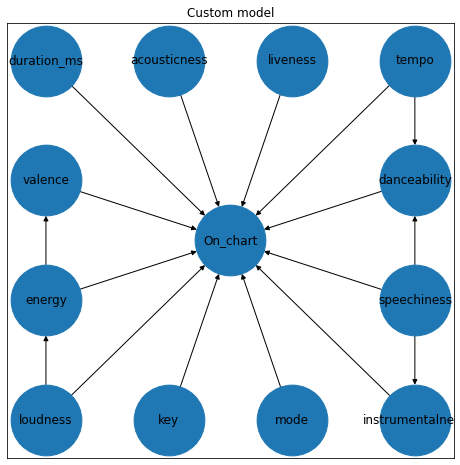

In [71]:
custom_model = BayesianModel([('tempo', 'danceability'), ('loudness', 'energy'),
                              ('speechiness', 'danceability'), ('speechiness', 'instrumentalness'),
                              ('energy', 'valence'),
                              ('duration_ms', 'On_chart'), ('energy', 'On_chart'),
                              ('key', 'On_chart'), ('mode', 'On_chart'),
                              ('acousticness', 'On_chart'), ('danceability', 'On_chart'),
                              ('instrumentalness', 'On_chart'), ('liveness', 'On_chart'),
                              ('loudness', 'On_chart'), ('speechiness', 'On_chart'),
                              ('valence', 'On_chart'), ('tempo', 'On_chart')])
pos = {'duration_ms': [-1.5, 2], 'acousticness': [-0.5, 2], 'liveness': [0.5, 2], 'tempo': [1.5,  2],
       'valence': [-1.5,  1.5], 'energy': [-1.5, 1], 'loudness': [-1.5, 0.5],
       'danceability': [1.5, 1.5], 'speechiness': [1.5,  1], 'instrumentalness': [1.5, 0.5],
       'On_chart': [0, 1.25],
       'key': [-0.5, 0.5], 'mode': [0.5, 0.5]}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

This network sums up our knowledge about the data: every feature potentially influence if a track will be a hit, and not the contrary. Also, according to Spotify API, danceability is caused by tempo and energy is caused by loudness. We can also state that the valence is caused by energy, that the daceability is caused by speechiness (a podcast is not danceable) and also instrumentalness is influenced by speechiness.

The problem with this network is that is too complex to calculate the weights. According to pgmpy it should requires to allocate an anrray of 3200 TB, so we will try with other solutions.

## Learning the network structure

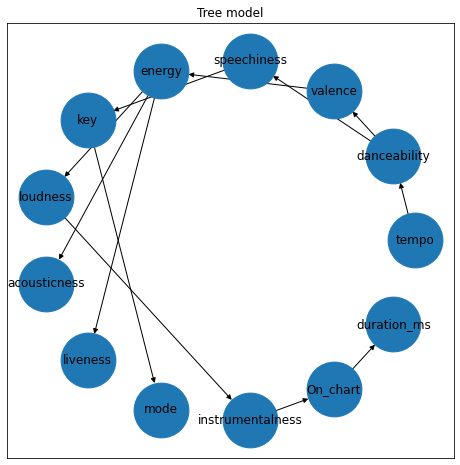

In [72]:
ts = TreeSearch(data=data, root_node='tempo')
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

The tree serach is an easy way to generate a network, but due to the nature of the problem, wgich makes difficoult to choose a root, it does not return good results. Changing the root we obtain similar results, so we need more complex algorithms, like HillCLimb Search.

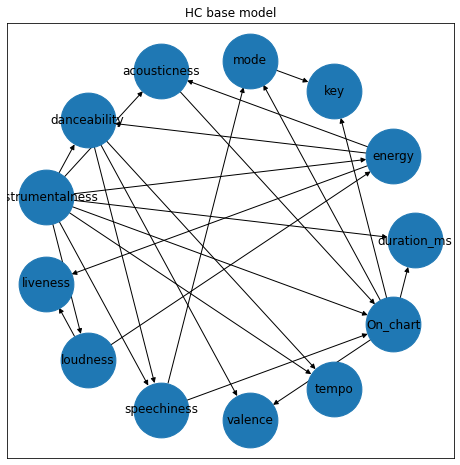

In [73]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianModel(hc_base_model.edges())

This is of course a more complex network, but there are some problems:
On_chart cannot be a contributor factor to anyone of the other features, since at first a track is made, with all its features, and only then it becomes a hit or not.

Another problem is that the dependendence tempo -> danceability we know to be true is missing.

All these problems will be solved applying some constraints. Unfortunately pgmpy requires too much RAM to generate this model, so we remove some features that from the previous graph seem to bee less influents: liveness


In [75]:
data_small = data.drop(columns=['liveness'])

In [ ]:
fixed_edges = [('tempo', 'danceability'), ('loudness', 'energy')]

# On_chart cannot be the cause of anything
black_list = [('On_chart', c) for c in data_small.columns]

scorer = BDeuScore(data=data_small)
hc = HillClimbSearch(data=data_small)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fixed_edges += [(c, 'On_chart') for c in ['valence', 'speechiness', 'instrumentalness', 'acousticness', 'mode', 'key', 'duration_ms']]
hc_inv_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 2, figsize=(8, 16))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[0], node_size=3000)
nx.draw_networkx(hc_inv_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[1], node_size=3000)
ax[0].set_title('HC constrained model')
ax[1].set_title('HC constrained model, with inverted arrows')

hc_constr_model = BayesianModel(hc_constr_model.edges())
hc_inv_model = BayesianModel(hc_inv_model.edges())




In [ ]:
# The custom one requires to RAM, so it is omitted
# Also, the tree model seems inaccurate, so it is omitted, too
hc_base_model.fit(data, estimator=MaximumLikelihoodEstimator)
hc_constr_model.fit(data_small, estimator=MaximumLikelihoodEstimator)

In [21]:
nodes = data_small.columns.values.tolist()
print('Considering nodes:', nodes)
print(f'The total number of valid independence assertions is {len(hc_constr_model.get_independencies().get_assertions())}')
print(f'Local semantics of the current model:\n{hc_constr_model.local_independencies(nodes)}')
print('Checking Markov blankets')
for node in nodes:
    print(f'The Markov blanket of node {node} is {hc_constr_model.get_markov_blanket(node)}')
print()

Considering nodes: ['energy', 'key', 'mode', 'acousticness', 'danceability', 'instrumentalness', 'loudness', 'speechiness', 'valence', 'tempo', 'On_chart']
The total number of valid independence assertions is 5629
Local semantics of the current model:
(energy ⟂ valence, danceability, tempo, key, speechiness, mode | loudness, instrumentalness)
(key ⟂ valence, loudness, acousticness, tempo, danceability, energy, speechiness, On_chart | instrumentalness, mode)
(mode ⟂ valence, loudness, tempo, danceability, energy, acousticness, On_chart | instrumentalness, speechiness)
(acousticness ⟂ valence, loudness, danceability, tempo, key, speechiness, mode | instrumentalness, energy)
(instrumentalness ⟂ danceability, tempo | valence, speechiness)
(loudness ⟂ valence, tempo, key, speechiness, mode | danceability, instrumentalness)
(speechiness ⟂ valence, tempo | danceability)
(valence ⟂ tempo, speechiness | danceability)
(On_chart ⟂ valence, loudness, danceability, tempo, key, energy, mode | instru

## Performing inferences

In [22]:
inferences = VariableElimination(hc_constr_model)

Acousticness, Intrumentalness and speechiness are the features that directly influence On_chart, but in which way? Also, among them which has the biggest impact?

In [25]:
answers_acoustic = []
answers_instrumental = []
answers_speech = []
for score in range(10):
    evidence = {"acousticness": score}
    answers_acoustic.append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])
    evidence = {"speechiness": score}        
    answers_speech.append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
    evidence = {"instrumentalness": score}
    answers_instrumental.append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])



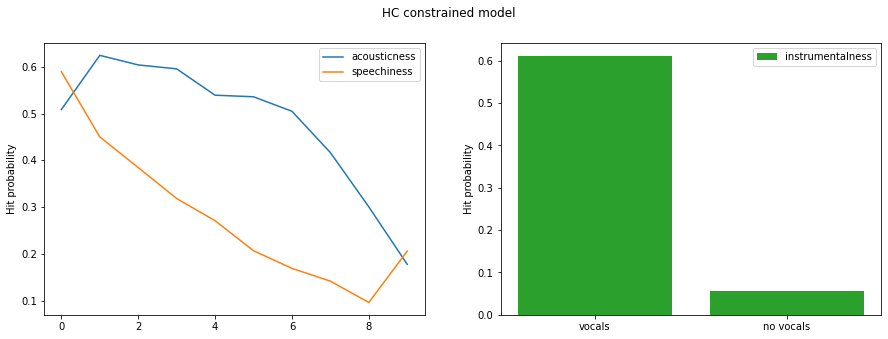

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"HC constrained model")
ax.set_ylabel('Hit probability')
ax.plot(answers_acoustic, label='acousticness')
ax.plot(answers_speech, label='speechiness')
ax.legend()
ax2 =axes[1]
ax2.bar(range(2), answers_instrumental, label='instrumentalness', color='C2')
ax2.legend()
ax2.set_xticks(range(2))
ax2.set_xticklabels(['vocals', 'no vocals'])
ax2.set_ylabel('Hit probability')
fig.savefig('query1')

Instrumentalness seems to have a huge impact: tracks with no vocals have less than 10% probability of be hits.

Speechiness has also an important role, and this was quite expected, since according to Spotify documentation a song should have a speechiness value between 0 and 0.33, with the exceptions of rap songs which span between 0.3 3and 0.66. Tracks above 0.66 are that are probably made entirely of spoken words, like podcasts.

We can also see that non-acoustic tracks have higher probabilities.

Now, what happens if we fix that our track has vocals?

In [47]:
answers = [[] for _ in range(10)]
for acousticness in range(10):
  for speechiness in range(10):
    evidence = {"acousticness": acousticness, "speechiness": speechiness, 'instrumentalness': 0}
    answers[acousticness].append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])

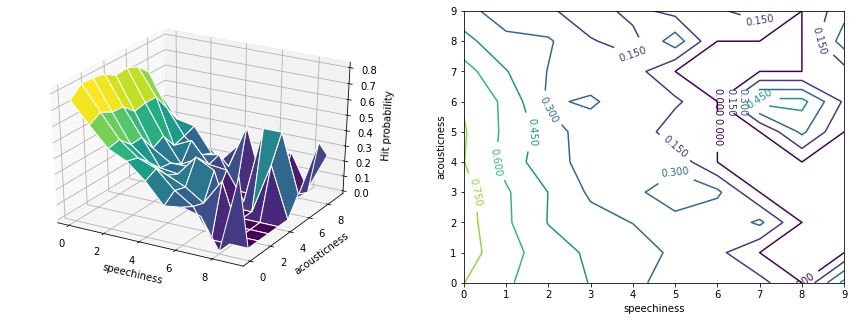

In [65]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(range(10), range(10))
Z = np.array(answers)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, edgecolor='white', cmap='viridis')
ax.set_xlabel('speechiness')
ax.set_ylabel('acousticness')
ax.set_zlabel('Hit probability')

ax = fig.add_subplot(1,2,2)
CS = ax.contour(Z)
ax.set_xlabel('speechiness')
ax.set_ylabel('acousticness')
ax.clabel(CS, inline=True, fontsize=10)
plt.show()

Let's check what happens when other features change

In [ ]:
answers = []
for i, feature in enumerate(['energy', 'danceability', 'valence', 'tempo', ''])
for score in range(10):
    evidence = {"acousticness": score}
    answers_acoustic.append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])
    evidence = {"speechiness": score}        
    answers_speech.append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
    evidence = {"instrumentalness": score}
    answers_instrumental.append(inferences.query(["On_chart"], evidence, show_progress=False).values[1])